In [1]:
%pip install -q --no-warn-conflicts malariagen_data
%pip install -q --no-warn-conflicts petl
%pip install -q colorama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 M

In [2]:
import allel
import malariagen_data
import numpy as np
import pandas as pd
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar

In [3]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.legend import Legend
from matplotlib.patches import Patch

In [4]:
import random
import functools
import petl as ptl
import itertools
import scipy
from collections import Counter
# Print style
from colorama import Fore, Back, Style
print(Fore.MAGENTA + 'To test the printing style')
print(Style.RESET_ALL) #to reset the printing style

To test the printing style



In [5]:
#Mounting Google Drive
#import os
#from google.colab import drive
#drive.mount("drive")

# make dir
#results_dir = '/home/mkient/gitrepos/IR/'
#os.makedirs(results_dir, exist_ok=True)
#os.chdir(results_dir)
#os.listdir()

In [6]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir
results_dir = "drive/MyDrive/"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [7]:
## Importing malariagen data set
ag3 = malariagen_data.Ag3("gs://vo_agam_release_master_us_central1/", pre=True)
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release_master_us_central1/
Data releases available : 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 3.10, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16
Results cache           : None
Cohorts analysis        : 20250815
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 15.4.0
Client location         : Iowa, United States (Google Cloud us-central1)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v15.4.0/Ag3.html

In [8]:
df_samples=ag3.sample_metadata(sample_sets='3.11',
                               sample_query='country=="Burkina Faso" and year >2021 and taxon != "unassigned"')
sets = list(df_samples.sample_set.unique())
#df_samples.groupby(['location','year','aim_species','sex_call']).size() #only one female from An. arabiensis - SK

### region and other sets
region = "2L:2358158-2431617"
transcript = 'AGAP004707-RD'
n_snps = 4000

dict_region = {'BF-01':'Boucle du Mouhoun','BF-02':'Cascades','BF-07':'Centre-Sud',
               'BF-08':'Est', 'BF-09':'Hauts-Bassins', 'BF-12':'Sahel'}

##import haplotypes data
haplo_dict = np.load('drive/MyDrive/sanger_analyses/resistance/VGSC/data/haplo_sample_id_all.npy',
                     allow_pickle=True).item()
map_dict = {}
for hap in haplo_dict.keys():
  hap_i = haplo_dict[hap]
  for sample_id in hap_i:
    map_dict[sample_id] = hap.split('_samples')[0]
len(map_dict.keys())

hap_labels = {
    'FVI/FVI': '995F+402V+1527I//995F+402V+1527I',
    'FL1T/LVI': '995F+402L(g>t)+1527T//995L+402V+1527I',
    'LL1T/LL1T':'995L+402L(g>t)+1527T//995L+402L(g>t)+1527T',
    'LL1T/LL2T': '995L+402L(g>t)+1527T//995L+402L(g>c)+1527T',
    'FL2T/LVI': '995F+402L(g>c)+1527T//995L+402V+1527I',
    'OD': 'Other diplotypes'
}

taxon = {
    "gambiae":"An. gambiae",
    "coluzzii":"An. coluzzii",
    "arabiensis":"An. arabiensis"
}

area_lab = {
    'Bana Village': 'BV',
    'Degue-Degue': 'DD',
    'Gama': 'GA',
    'Souroukoudinga': 'SK',
    'Sideradougou': 'SI',
    'Nagare': 'NG',
    'Nassan': 'NS',
    'Ouro-Hesso': 'OH',
    'Po-Dongo': 'Po',
}

df_samples['area_lab'] = df_samples.location.map(area_lab)
df_samples['haplo_id'] = df_samples.sample_id.map(map_dict)

#####
df_samples['region'] = df_samples['admin1_iso'].map(dict_region)
sets = list(df_samples.sample_set.unique())

#Create population column
s1, s2, pop_labels, pop_colors, = [], [], {}, {}
for iso, sp in zip(df_samples.location, df_samples.taxon):
  s1.append(iso[:4]+'_'+sp[:3])
df_samples.insert(4, 'population', s1)
pop_ids = list(df_samples.population.unique())

s3 = []
for pop, haplo in zip(df_samples.population, df_samples.haplo_id):
  s3.append(pop+'_'+haplo)
s4 = []
for admin, sp in zip(df_samples.admin1_iso, df_samples.taxon):
  s4.append(admin+'_'+str(sp))

df_samples.insert(4, 'pop_haplo', s3)
df_samples.insert(4, 'region_taxon', s4)
pop_hap = list(df_samples.pop_haplo.unique())
pop_region = list(df_samples.region_taxon.unique())

## labels
#pop_labels = {}
#for popi in pop_ids:
#  ghost_df = df_samples.query(f'population=="{popi}"')
#  pop_labels[popi]=ghost_df.location.unique()[0][:4]+'_'+ghost_df.aim_species.unique()[0][:4]

#pop_labels_h = {}
#for popi in pop_hap:
#  ghost_df = df_samples.query(f'pop_haplo=="{popi}"')
#  pop_labels_h[popi]=ghost_df.location.unique()[0][:4]+'_'+ghost_df.aim_species.unique()[0][:4]+'_'+ghost_df.pop_haplo.unique()

pop_labels_r = {}
for popi in pop_region:
  ghost_df = df_samples.query(f'region_taxon=="{popi}"')
  if len(ghost_df.location.unique())>0:
    pop_labels_r[popi]=ghost_df.admin1_iso.unique()[0][:5]+'_'+ghost_df.taxon.unique()[0]

#pop_id
for idx, sp, in zip(df_samples.location, df_samples.taxon):
  w = idx.split(' ')[0][:4]
  s2.append(w+' $An.'+sp)
val = list(Counter(s2).keys())
for idx, vl in zip(pop_ids, val):
  pop_labels[idx]=vl
#pop_labels

pop_labels_h, sh = {}, []
for idx, sp, hap in zip(df_samples.location, df_samples.taxon, df_samples.haplo_id):
  w = idx.split(' ')[0][:4]
  sh.append(w+'-'+sp[:4]+' ('+hap+')')
val1 = list(Counter(sh).keys())
for idx, vl in zip(pop_hap, val1):
  pop_labels_h[idx]=vl
#pop_labels_h

#pop_cohort
coh_pop1 = dict([(f"{p[0]}", list(df.index)) for (p), df in df_samples.reset_index().groupby(['population'])])
coh_pop2 = dict([(f"{p[0]}", list(df.index)) for (p), df in df_samples.reset_index().groupby(['pop_haplo'])])
coh_pop3 = dict([(f"{p[0]}", list(df.index)) for (p), df in df_samples.reset_index().groupby(['region_taxon'])])
coh_pop = {**coh_pop1, **coh_pop2, **coh_pop3}

#pop_colors
colored = sns.color_palette("husl", len(pop_ids))
for i in range(len(pop_ids)):
  pop_colors[pop_ids[i]] = colored[i]

pop_colors_hap={}
colored2 = sns.color_palette("husl", len(pop_hap))
for i in range(len(pop_hap)):
  pop_colors_hap[pop_hap[i]] = colored2[i]

select_pop1 = [key for key in df_samples.population.unique() if df_samples.query(f'population=="{key}"').shape[0]>=10]
select_pop2 = [key for key in df_samples.pop_haplo.unique() if df_samples.query(f'pop_haplo=="{key}"').shape[0]>=10]

select_pop3 = [key for key in df_samples.region_taxon.unique() if df_samples.query(f'region_taxon=="{key}"').shape[0]>=10]

select_pop = select_pop1 + select_pop2 + select_pop3
col_ls, gamb_ls, arab = [], [], []
for i in select_pop:
    if len(i.split('_'))>2:
        if i.split('_')[1]=='col':
            col_ls.append(i)
        elif i.split('_')[1]=='gam':
            gamb_ls.append(i)
        elif i.split('_')[1]=='ara':
            arab.append(i)
        else:
            pass

len(select_pop)
select_pop12 = ['Bana_col','Sour_col','Side_col','Po-D_col','Gama_col','Naga_col',
                'Nass_col','Ouro_col','Sour_gam','Side_gam','Po-D_gam','Gama_gam',
                'Naga_gam','Po-D_ara','Gama_ara','Nass_ara','Ouro_ara']

select_pop111 = ['Sour_ara','Side_ara', 'Po-D_ara','Gama_ara','Nass_ara','Naga_ara','Ouro_ara',
                 'Bana_col', 'Sour_col','Side_col','Po-D_col', 'Gama_col', 'Nass_col', 'Naga_col',
                 'Ouro_col', 'Sour_gam','Side_gam', 'Degu_gam', 'Po-D_gam', 'Gama_gam', 'Naga_gam']

select_pop21 = ['Bana_col_FVI/FVI', 'Bana_col_FL1T/LVI', 'Bana_col_FL2T/LVI', 'Bana_col_LL1T/LL1T',
                'Sour_col_FVI/FVI', 'Sour_col_FL1T/LVI',  'Po-D_col_FL1T/LVI', 'Gama_col_FL1T/LVI',
                'Gama_col_LL1T/LL1T', 'Nass_col_FL1T/LVI', 'Nass_col_LL1T/LL1T', 'Naga_col_FVI/FVI',
                'Naga_col_FL1T/LVI', 'Naga_col_LL1T/LL1T', 'Ouro_col_FVI/FVI', 'Ouro_col_FL1T/LVI',
                'Ouro_col_LL1T/LL1T', 'Sour_gam_FVI/FVI', 'Side_gam_FVI/FVI', 'Po-D_gam_FVI/FVI',
                'Gama_gam_FVI/FVI', 'Naga_gam_FVI/FVI', 'Gama_ara_OD', 'Nass_ara_OD', 'Ouro_ara_OD']

print(Fore.MAGENTA, len(select_pop1) == len(select_pop12), sorted(select_pop12) == sorted(select_pop1))
print(len(select_pop2) == len(select_pop21), sorted(select_pop21) == sorted(select_pop2))
pop_idx = []
for pop in select_pop:
  pop_idx = pop_idx + coh_pop[pop]
print(len(pop_idx))
print(Style.RESET_ALL) #to reset the printing style

 True True
True True
1708



In [9]:
#haplo_dict.keys()

In [10]:
#select_pop2

## Computting diversity stats

In [11]:
#To access to the genotypes within the 3L chromosomes
ds_snps = ag3.snp_calls(region="2L:2358158-2431617", sample_sets=sets)

# Take some SNP in the X chromosomes
ds_pos = allel.SortedIndex(ds_snps['variant_position'].values)

# To filter the SNP dataset and warp the dataset to GT array
filt = 'gamb_colu_arab'
filt_val = ds_snps[f"variant_filter_pass_{filt}"].values

## Compute genotype & count the number of alleles
with ProgressBar():
  ds_gt_filtered = allel.GenotypeDaskArray(ds_snps["call_genotype"][filt_val].data).compute()
  ds_ac = ds_gt_filtered.count_alleles()

is_var = ds_ac.is_variant()
pos_filt = allel.SortedIndex(ds_snps['variant_position'][filt_val].values)
pos_filt_var = pos_filt[is_var]

[########################################] | 100% Completed | 2.32 s


In [12]:
## segregating sites
print(Fore.MAGENTA, ds_ac.count_segregating(), 'segregating sites', ds_ac.count_segregating()/(2431617-2358158))
print(ds_ac.count_variant(), 'variants sites', ds_ac.count_variant()/(2431617-2358158))
print(ds_ac.is_biallelic().sum(), 'biallelic sites')
print(ds_ac.count_segregating()-ds_ac.is_biallelic().sum(), 'sites are not biallelic')
print(100*(ds_ac.count_segregating()-ds_ac.is_biallelic().sum())/ds_ac.count_segregating(), '% sites are not biallelic')

 5121 segregating sites 0.0697123565526348
5140 variants sites 0.06997100423365414
4753 biallelic sites
368 sites are not biallelic
7.186096465534075 % sites are not biallelic


In [13]:
## sites rates

In [14]:
### synonymous vs non-synonymous mutations

In [15]:
## nucleotide diversity vs tajima's D and WT
pi = allel.sequence_diversity(pos_filt, ds_ac)
D = allel.tajima_d(ds_ac, pos_filt)
w_theta = allel.watterson_theta(pos_filt, ds_ac)
print(Fore.MAGENTA+'pi = ', pi)
print('D = ', D)
print('w_theta = ', w_theta)

pi =  0.0014365613331386588
D =  -2.445232357248871
w_theta =  0.00897212820778534


In [16]:
## nucleotide diversity vs tajima's D and WT
coh_div = {
    'overall': 'year > 2021 and taxon != "unassigned"',
    'coluzzii': 'year > 2021 and taxon == "coluzzii"',
    'gambiae': ' year > 2021 and taxon == "gambiae"',
    'arabiensis': 'year > 2021 and taxon == "arabiensis"',
}

### diversity stats
coh_stats = ag3.diversity_stats(sample_sets=sets,cohorts=coh_div,cohort_size=5,
                              region='2L:2358158-2431617',site_mask="gamb_colu_arab",
                              site_class=None)



Compute SNP allele counts:   0%|          | 0/89 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/91 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/129 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/99 [00:00<?, ?it/s]

In [17]:
coh_stats[['cohort','theta_pi_estimate','theta_w_estimate', 'tajima_d_estimate']]

,cohort,theta_pi_estimate,theta_w_estimate,tajima_d_estimate
0,overall,0.002158,0.001924,0.611920
1,coluzzii,0.002207,0.001855,0.953161
2,gambiae,0.000746,0.001201,-1.905331
3,arabiensis,0.001755,0.002041,-0.705490


In [18]:
#coh_stats

In [19]:
## within pop diversity
col_set = dict([(f"{p[0]}", list(df.index)) for (p), df in df_samples.reset_index().groupby(['taxon'])])
ds_col_ac = ds_gt_filtered.take(col_set['coluzzii'],axis=1).count_alleles(max_allele=3)
ds_gamb_ac = ds_gt_filtered.take(col_set['gambiae'],axis=1).count_alleles(max_allele=3)
ds_arab_ac = ds_gt_filtered.take(col_set['arabiensis'],axis=1).count_alleles(max_allele=3)

## diversity stats
print(Fore.MAGENTA+'Diversity in the An. coluzzii pop')
print(allel.sequence_diversity(pos_filt, ds_col_ac))
print(allel.tajima_d(ds_col_ac, pos_filt))
print(allel.watterson_theta(pos_filt, ds_col_ac))
print(ds_col_ac.count_segregating(), 'segregating sites', ds_col_ac.count_segregating()/(2431617-2358158))
print(ds_col_ac.count_variant(), 'variants sites', ds_col_ac.count_variant()/(2431617-2358158))
print(ds_col_ac.is_biallelic().sum(), 'biallelic sites')
print(ds_col_ac.count_segregating()-ds_col_ac.is_biallelic().sum(), 'sites are not biallelic')
print(100*(ds_col_ac.count_segregating()-ds_col_ac.is_biallelic().sum())/ds_col_ac.count_segregating(), '% sites are not biallelic')

print('\n')
print(Fore.MAGENTA+'Diversity in the An. gambiae pop')
print(allel.sequence_diversity(pos_filt, ds_gamb_ac))
print(allel.tajima_d(ds_gamb_ac, pos_filt))
print(allel.watterson_theta(pos_filt, ds_gamb_ac))
print(ds_gamb_ac.count_segregating(), 'segregating sites', ds_gamb_ac.count_segregating()/(2431617-2358158))
print(ds_gamb_ac.count_variant(), 'variants sites', ds_gamb_ac.count_variant()/(2431617-2358158))
print(ds_gamb_ac.is_biallelic().sum(), 'biallelic sites')
print(ds_gamb_ac.count_segregating()-ds_gamb_ac.is_biallelic().sum(), 'sites are not biallelic')
print(100*(ds_gamb_ac.count_segregating()-ds_gamb_ac.is_biallelic().sum())/ds_gamb_ac.count_segregating(), '% sites are not biallelic')

print('\n')
print(Fore.MAGENTA+'Diversity in the An. arabiensis pop')
print(allel.sequence_diversity(pos_filt, ds_arab_ac))
print(allel.tajima_d(ds_arab_ac, pos_filt))
print(allel.watterson_theta(pos_filt, ds_arab_ac))
print(ds_arab_ac.count_segregating(), 'segregating sites', ds_arab_ac.count_segregating()/(2431617-2358158))
print(ds_arab_ac.count_variant(), 'variants sites', ds_arab_ac.count_variant()/(2431617-2358158))
print(ds_arab_ac.is_biallelic().sum(), 'biallelic sites')
print(ds_arab_ac.count_segregating()-ds_arab_ac.is_biallelic().sum(), 'sites are not biallelic')
print(100*(ds_arab_ac.count_segregating()-ds_arab_ac.is_biallelic().sum())/ds_arab_ac.count_segregating(), '% sites are not biallelic')


Diversity in the An. coluzzii pop
0.0013981748838184638
-2.3987789138727145
0.007345260451430636
3978 segregating sites 0.05415265658394479
3997 variants sites 0.05441130426496413
3754 biallelic sites
224 sites are not biallelic
5.63097033685269 % sites are not biallelic


Diversity in the An. gambiae pop
0.001566006369820529
-1.431188989461248
0.002832955581094743
1244 segregating sites 0.01693461658884548
1272 variants sites 0.017315781592452933
1220 biallelic sites
24 sites are not biallelic
1.9292604501607717 % sites are not biallelic


Diversity in the An. arabiensis pop
0.001434111160409861
-1.6233828579425031
0.0028163580478041505
1144 segregating sites 0.015573313004533141
1172 variants sites 0.015954478008140597
1131 biallelic sites
13 sites are not biallelic
1.1363636363636365 % sites are not biallelic


### Non-synonymous SNP

In [20]:
## define samples cohorts
cohorts, coh112, cohorts_, pop_list, pop_list1 = {}, {}, {}, [],[]
for loca in df_samples.location.unique():
    loca_sample = df_samples.query(f"location == '{loca}'")
    for species in loca_sample.taxon.unique():
      sp_sample=loca_sample.query(f'taxon=="{species}"')
      key2 = loca[:4]+'_'+species[:3]
      key3 = loca+'[An. '+species+']'
      cohorts_[key2] = f"country == 'Burkina Faso' and location=='{loca}' and taxon == '{species}'"
      pop_list1.append(key3)
      for year in sp_sample.year.unique():
        key = loca[:4]+'_'+species[:3]+'_'+str(year)
        key1 = loca+'[An. '+species+' ('+ str(year)+')]'
        sample_list = list(df_samples.query(f"country == 'Burkina Faso' and location=='{loca}' and taxon == '{species}' and year == {year}").sample_id)
        cohorts[key] = f"country == 'Burkina Faso' and location=='{loca}' and taxon == '{species}' and year == {year}"
        coh112[key] = "sample_id in ['"+ "', '".join(sample_list) + "']"
        pop_list1.append(key1)

## Cohorts size
cohorts_size, cohorts_size_ = {}, {}
for coh in cohorts.keys():
  cohorts_size[coh] = df_samples.query(f'{cohorts[coh]}').shape[0]
for coh in cohorts_.keys():
  cohorts_size_[coh] = df_samples.query(f'{cohorts_[coh]}').shape[0]

In [21]:
SNP_tab = ag3.snp_allele_frequencies(transcript=transcript, sample_sets='3.11',
                                     cohorts=coh112, min_cohort_size=5)
SNP_tab.reset_index(drop=True, inplace=True)

Load SNP genotypes:   0%|          | 0/65 [00:00<?, ?it/s]

Compute allele frequencies:   0%|          | 0/21 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/20322 [00:00<?, ?it/s]

In [22]:
#SNP_tab.columns

In [23]:
#SNP_tab['effect'].value_counts()

In [24]:
#SNP_tab['effect'].value_counts()

In [25]:
ns_SNPdf = SNP_tab.query('pass_gamb_colu_arab == True and effect=="NON_SYNONYMOUS_CODING"')

In [26]:
fh = [1, 2, 0.9, 0.009, 0, 0, 7, 0, 0, 0.0]
len(fh), np.count_nonzero(fh)

(10, 5)

In [27]:
np.count_nonzero(ns_SNPdf.frq_Bana_col_2022), len(ns_SNPdf.frq_Bana_col_2022)

(60, 392)

In [28]:
ns_dict,ns_list, len_snp = {}, [], []
for col in ns_SNPdf.columns:
    if col.split('_')[0]=='frq':
        key=col.split('_')[1]+'_'+col.split('_')[2]
        ns_dict[key] = np.count_nonzero(ns_SNPdf[f'{col}'])
        ns_list.append(np.count_nonzero(ns_SNPdf[f'{col}']))
        len_snp.append(len(ns_SNPdf[f'{col}']))

In [29]:
#ns_list

In [30]:
#len(ns_dict)

In [31]:
ns_dict.keys()

dict_keys(['Bana_col', 'Sour_col', 'Sour_gam', 'Sour_ara', 'Nass_col', 'Nass_ara', 'Side_col', 'Side_gam', 'Side_ara', 'Degu_gam', 'Po-D_ara', 'Po-D_gam', 'Po-D_col', 'Gama_ara', 'Gama_col', 'Gama_gam', 'Ouro_col', 'Ouro_ara', 'Naga_gam', 'Naga_col', 'Naga_ara'])

In [32]:
#SNP_tab.columns

## compute allele counts pop - dict

In [33]:
ac_pop = {}
with ProgressBar():
  for pop in select_pop:
    ac_pop[pop] = ds_gt_filtered.take(coh_pop[pop],axis=1).count_alleles(max_allele=3)

In [34]:
@functools.lru_cache(maxsize=None)
def load_ac(pop):
    ac_spi = ac_pop[pop]
    return ac_spi
#load_ac(pop='Nass_ara')

In [35]:
## function
def comput_stats1(ipop,pos):
    samples = ds_gt_filtered.take(coh_pop[ipop],axis=1).n_samples
    iac = ds_gt_filtered.take(coh_pop[ipop],axis=1).count_alleles(max_allele=3)
    s = iac.count_segregating()
    s2 = iac.is_biallelic().sum()
    pi = allel.sequence_diversity(pos, iac)
    D = allel.tajima_d(iac, pos)
    w = allel.watterson_theta(pos, iac)
    return samples, s, s2, pi, D, w

comput_stats1(ipop='Bana_col_FVI/FVI', pos=pos_filt)

(26,
 np.int64(501),
 np.int64(499),
 np.float64(0.0011353704563774871),
 np.float64(-0.8986472142503081),
 np.float64(0.001509254275868934))

In [36]:
#coh_pop.keys()

In [37]:
#select_pop21

In [38]:
## compute div - dict - div
#build = ['samples', 'SNP', 'bi-SNP','pi','D','w']
#stats_seg = {}
#for idx in select_pop:
#    stats_seg[idx] = comput_stats1(ipop=idx, pos=pos_filt)

## convert to df
#stats_seg_df = pd.DataFrame.from_dict(stats_seg, orient='index').reset_index()
#stats_seg_df.columns = ['pops','samples','SNP', 'bi-SNP','pi','D','w']
#stats_seg_df.to_excel('drive/MyDrive/sanger_analyses/resistance/VGSC/data/stats_div_pop.xlsx')

In [39]:
## compute div - dict - div
build = ['samples', 'SNP', 'bi-SNP','pi','D','w']
sorted_list = sorted(select_pop111, key=lambda x: x.split('_')[1])
stats_seg = {}
for idx in sorted_list:
    stats_seg[idx] = comput_stats1(ipop=idx, pos=pos_filt)

## convert to df
stats_seg_df = pd.DataFrame.from_dict(stats_seg, orient='index').reset_index()
stats_seg_df.columns = ['pops','samples','SNP', 'bi-SNP','pi','D','w']
stats_seg_df['ns_SNP']=stats_seg_df.pops.map(ns_dict)
stats_seg_df.to_excel('drive/MyDrive/sanger_analyses/resistance/VGSC/data/stats_div_pop.xlsx')

In [40]:
#stats_seg_df['pi_err'] = np.sqrt(stats_seg_df.pi*(1-stats_seg_df.pi)/stats_seg_df.samples)
#stats_seg_df

In [41]:
## compute div - dict - div
#build = ['SNP', 'bi-SNP','pi','D','w']
#stats_seg1 = {}
#for idx in select_pop:
#    stats_seg1[idx] = comput_stats1(ipop=idx, pos=pos_filt)

## convert to df
#stats_seg_df1 = pd.DataFrame.from_dict(stats_seg1, orient='index').reset_index()
#stats_seg_df1.columns = ['pops','SNP', 'bi-SNP','pi','D','w']

In [42]:
#stats_seg_df

In [43]:
#load_ac(pop='Bana_col_FF/FF')

## diversity stats

In [44]:
### diversity stats
div_df = ag3.diversity_stats(sample_sets=sets,cohorts=cohorts,cohort_size=5,
                             region='2L:2358158-2431617',site_mask="gamb_colu_arab",
                             site_class=None)

Cohort (Bana_gam_2022) has insufficient samples (4) for requested cohort size (5), dropping.
Cohort (Nass_gam_2022) has insufficient samples (2) for requested cohort size (5), dropping.
Cohort (Degu_col_2022) has insufficient samples (4) for requested cohort size (5), dropping.


Compute SNP allele counts:   0%|          | 0/43 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/33 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/27 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/17 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/27 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/27 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/27 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/27 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/27 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/15 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/27 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/27 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/27 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/35 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/35 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/35 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/33 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/27 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/43 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/49 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/35 [00:00<?, ?it/s]

In [45]:
div_df.to_excel('drive/MyDrive/sanger_analyses/resistance/VGSC/data/div_df.xlsx')

In [46]:
#df1 = div_df.copy()

In [47]:
#sf = df1['tajima_d_std_err']
#df1['tajima_d_std_err'].where(sf<1, 0.088774)

In [48]:
#cohorts

In [49]:
### Manip
div_df1 = div_df.copy()
div_df1['location'] = [i[:4] for i in div_df.cohort]

##
loc_order = ['Sideradougou','Degue-Degue','Bana Village', 'Souroukoudinga', 'Po-Dongo','Gama',
            'Nassan','Nagare','Ouro-Hesso']
loc_order1 = [s[:4] for s in loc_order]

##
label_sp = ['An. arabiensis', 'An. coluzzii', 'An. gambiae s.s.']
label_sp1 = ['Aara', 'Acol', 'Agam']
col_pal = ['#929591', '#A9561E', '#7BC8F6']

col12= ['#929591', '#929591', '#929591', '#929591', '#929591', '#929591', '#929591',
        '#A9561E', '#A9561E','#A9561E','#A9561E','#A9561E','#A9561E', '#A9561E','#A9561E',
        '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6','#7BC8F6']

## reorder
div_df1['location'] = pd.Categorical(div_df1['location'],categories=loc_order1, ordered=True)
div_df1 = div_df1.sort_values(by=['taxon','location'])
sf = div_df1['tajima_d_std_err']
div_df1['tajima_d_std_err'] = div_df1['tajima_d_std_err'].where(sf<1, sf-1)

loca = list(div_df1['location'])
#div_df1.to_excel()

In [50]:
#div_df1

In [51]:
#div_df1[['cohort','theta_pi_estimate','theta_w_estimate', 'tajima_d_estimate','tajima_d_std_err']]

In [52]:
#df12.where (df12['tajima_d_std_err']<1, 0.088774, inplace=True)
#df12

In [53]:
#df_list = []
#for loc in df_samples.location.unique():
#  div_li = ag3.diversity_stats(sample_sets='3.11', sample_query=f"country == 'Burkina Faso' and location == '{loc}'",
#                               cohorts="admin2_year",cohort_size=10, region=region,site_mask="gamb_colu_arab",
#                               site_class="CDS_DEG_4")
#  div_li['location'] = np.repeat(loc, len(div_li))
#  df_list.append(div_li)
#
#loc_stats = pd.concat(df_list, axis=0)
#loc_stats

In [54]:
##
#label_sp = ['An. arabiensis', 'An. coluzzii', 'An. gambiae s.s.']
#col_pal = ['#929591', '#A9561E', '#7BC8F6']

#col12= ['#929591', '#929591', '#929591', '#929591',
#        '#A9561E', '#A9561E','#A9561E','#A9561E','#A9561E','#A9561E', '#A9561E','#A9561E','#A9561E','#A9561E',
#       '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6','#7BC8F6', '#7BC8F6', '#7BC8F6',
#        '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6', '#7BC8F6','#7BC8F6', '#7BC8F6']

#loc_order1 = ['Cascades', 'Hauts-Bassins', 'Centre-Sud', 'Est', 'Boucle du Mouhoun', 'Sahel']
#loc_order = ['Sideradougou','Bana Village', 'Souroukoudinga', 'Po-Dongo','Gama',
#            'Nassan','Nagare','Ouro-Hesso']
#loc_stats['location'] = pd.Categorical(loc_stats['location'],categories=loc_order, ordered=True)
#loc_stats = loc_stats.sort_values(by=['taxon','location'])
#loc_stats_sel = loc_stats.query('year==2022')
#loc_stats_sel

In [55]:
def fig_diversity(x, h, err, cp=3, lw=1, ylim=(0,0.03), ax=None, color='red', figsize=(5, 4),
                  title=None, xtick_lab=None,bottom=False, top = True, xlab=None,
                  ylab=None, fig_name=None, side=None):
  #define ax
  if ax is None:
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine(ax=ax, bottom=bottom, top = top, offset=2)

  #plot
  ax.bar(x=x,height=h, yerr=err, color=color,capsize=cp, error_kw={'elinewidth': lw},
         tick_label =None)

   # Plot title
  if title:
    ax.set_title(f'{title}')

  # Customize plot
  if ylab:
    ax.set_ylabel(f'{ylab}')
  if xlab:
    ax.set_xlabel(f'{xlab}')

  #ax setting
  ax.set_ylim(*ylim)
  if xtick_lab:
    if top is True:
      ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')
    else:
      ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='left')

  if fig_name:
    fig.savefig(f"drive/MyDrive/sanger_analyses/resistance/VGSC/savefig/{fig_name}.png", dpi=300, bbox_inches='tight',transparent=False)
  return ax

/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')


<Axes: ylabel='$\\theta_{\\pi}$'>

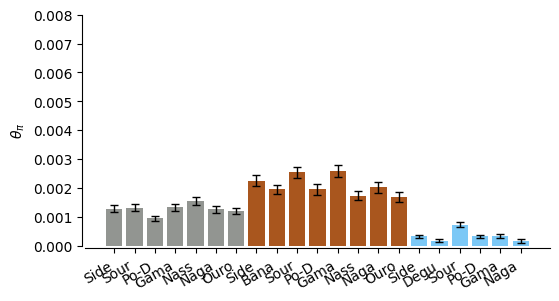

In [56]:
fig_diversity(x=div_df1.cohort, h=div_df1.theta_pi_estimate,err=div_df1.theta_pi_std_err,
              figsize=(6,3),cp=3,ylim=(0,0.008),lw=1,
              color=col12, xtick_lab=loca, ylab=r'$\theta_{\pi}$', fig_name=None)

/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')
/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')


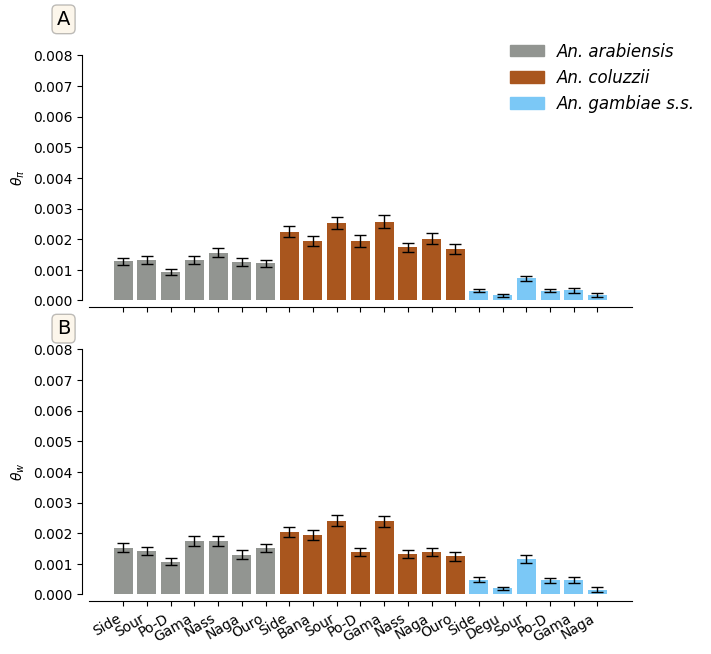

In [57]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(2, 1, hspace = 0.2, wspace=0.15, figure=fig)

ax0 = plt.subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.theta_pi_estimate,err=div_df1.theta_pi_std_err,ax=ax0,cp=4,
              ylim=(0,0.008),
              xtick_lab=['']*len(loca), color=col12, ylab=r'$\theta_{\pi}$', fig_name=None)
ax0.text(-2.8, 0.009, 'A', size=14,bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax1 = plt.subplot(gs[1, 0])
sns.despine(ax=ax1, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.theta_w_estimate,err=div_df1.theta_w_std_err,ax=ax1,
              cp=4,ylim=(0,0.008), xtick_lab=loca, color=col12, ylab=r'$\theta_w$', fig_name=None)
ax1.text(-2.8, 0.0085, 'B', size=14,bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

cmap = dict(zip(label_sp, col_pal))
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
#patches = [mpl.patches.Patch(color=v, label=k) for k, v in cmap.items]
fig.legend(title=' ', labels=label_sp, handles=patches, bbox_to_anchor=(1, 0.94), loc='upper right',
           borderaxespad=0,ncol=1, frameon=False, prop={'size':12, 'style': 'italic'})

/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')
/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')
/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')


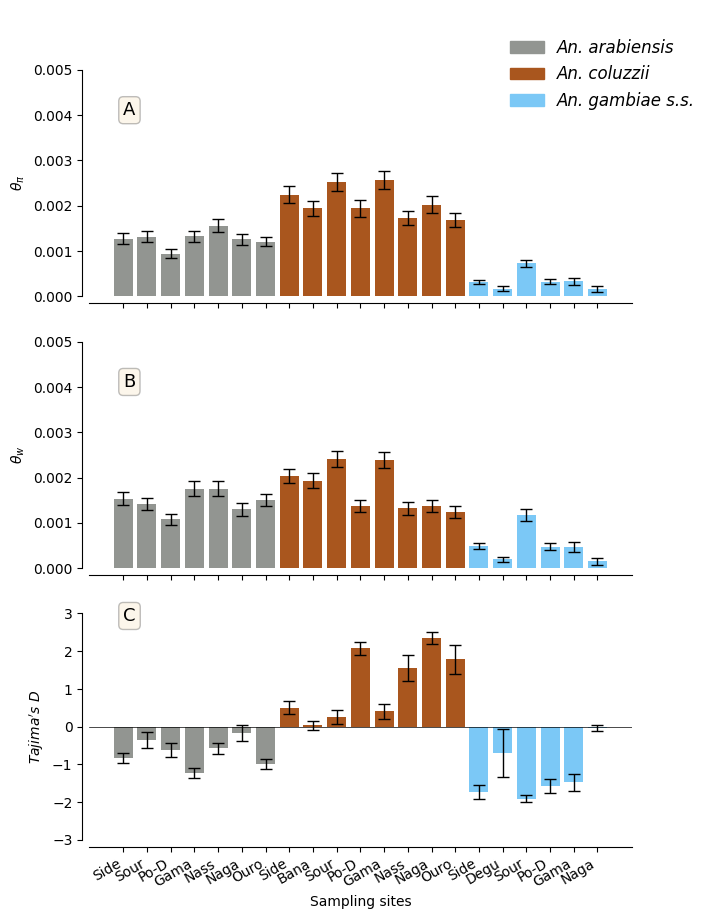

In [58]:
fig = plt.figure(figsize=(7,10))
gs = GridSpec(3, 1, hspace = 0.2, wspace=0.15, figure=fig)

ax0 = plt.subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.theta_pi_estimate,err=div_df1.theta_pi_std_err,ax=ax0,cp=4,
              ylim=(0,0.005),
              xtick_lab=['']*len(loca), color=col12, ylab=r'$\theta_{\pi}$', fig_name=None)
ax0.text(0, 0.004, 'A', size=13,bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax1 = plt.subplot(gs[1, 0])
sns.despine(ax=ax1, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.theta_w_estimate,err=div_df1.theta_w_std_err,ax=ax1,
              cp=4,ylim=(0,0.005), xtick_lab=['']*len(loca), color=col12, ylab=r'$\theta_w$', fig_name=None)
ax1.text(0, 0.004, 'B', size=13,bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax2 = plt.subplot(gs[2, 0])
sns.despine(ax=ax2, bottom=False, top = True, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.tajima_d_estimate.fillna(0), err=div_df1.tajima_d_std_err.fillna(0),
              cp=4, ax=ax2, ylim=(-3, 3), xtick_lab=loca, color=col12, ylab="$Tajima's$ $D$", bottom=False,
              top = True,xlab='Sampling sites')
ax2.axhline(y=0, xmin=0, xmax=22, color='k', linestyle='-', linewidth=0.5)
ax2.text(0,  2.8, 'C', size=13, bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

cmap = dict(zip(label_sp, col_pal))
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
#patches = [mpl.patches.Patch(color=v, label=k) for k, v in cmap.items]
fig.legend(title=' ', labels=label_sp, handles=patches, bbox_to_anchor=(1, 0.94), loc='upper right',
           borderaxespad=0,ncol=1, frameon=False, prop={'size':12, 'style': 'italic'})

fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/div_stats.png',dpi=300, bbox_inches='tight')

/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')
/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')
/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')


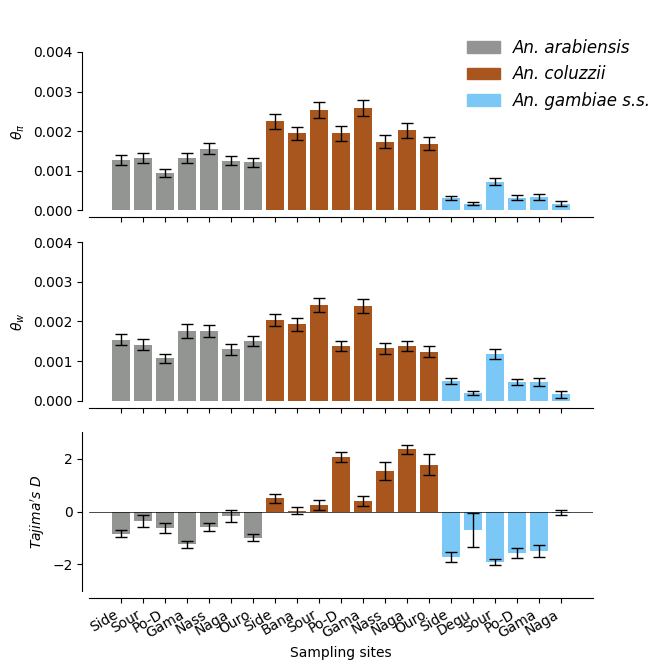

In [59]:
fig = plt.figure(figsize=(6.5,7))
gs = GridSpec(3, 1, hspace = 0.2, wspace=0.15, figure=fig)

ax0 = plt.subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.theta_pi_estimate,err=div_df1.theta_pi_std_err,ax=ax0,cp=4,
              ylim=(0,0.004),
              xtick_lab=['']*len(loca), color=col12, ylab=r'$\theta_{\pi}$', fig_name=None)
#ax0.text(0, 0.004, 'A', size=13,bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax1 = plt.subplot(gs[1, 0])
sns.despine(ax=ax1, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.theta_w_estimate,err=div_df1.theta_w_std_err,ax=ax1,
              cp=4,ylim=(0,0.004), xtick_lab=['']*len(loca), color=col12, ylab=r'$\theta_w$', fig_name=None)
#ax1.text(0, 0.004, 'B', size=13,bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax2 = plt.subplot(gs[2, 0])
sns.despine(ax=ax2, bottom=False, top = True, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.tajima_d_estimate.fillna(0), err=div_df1.tajima_d_std_err.fillna(0),
              cp=4, ax=ax2, ylim=(-3, 3), xtick_lab=loca, color=col12, ylab="$Tajima's$ $D$", bottom=False,
              top = True,xlab='Sampling sites')
ax2.axhline(y=0, xmin=0, xmax=22, color='k', linestyle='-', linewidth=0.5)
#ax2.text(0,  2.8, 'C', size=13, bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

cmap = dict(zip(label_sp, col_pal))
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
#patches = [mpl.patches.Patch(color=v, label=k) for k, v in cmap.items]
fig.legend(title=' ', labels=label_sp, handles=patches, bbox_to_anchor=(1, 0.94), loc='upper right',
           borderaxespad=0,ncol=1, frameon=False, prop={'size':12, 'style': 'italic'})

fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/div_stats12.png',dpi=300, bbox_inches='tight')

/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')
/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')
/tmp/ipython-input-390457198.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xtick_lab[v] for v in ax.get_xticks()], rotation=30, ha='right')


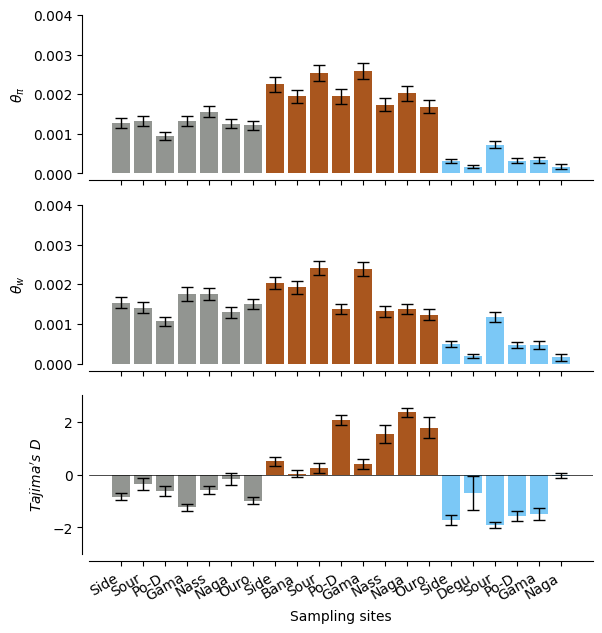

In [60]:
fig = plt.figure(figsize=(6.5,7))
gs = GridSpec(3, 1, hspace = 0.2, wspace=0.15, figure=fig)

ax0 = plt.subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.theta_pi_estimate,err=div_df1.theta_pi_std_err,ax=ax0,cp=4,
              ylim=(0,0.004),
              xtick_lab=['']*len(loca), color=col12, ylab=r'$\theta_{\pi}$', fig_name=None)
#ax0.text(0, 0.004, 'A', size=13,bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax1 = plt.subplot(gs[1, 0])
sns.despine(ax=ax1, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.theta_w_estimate,err=div_df1.theta_w_std_err,ax=ax1,
              cp=4,ylim=(0,0.004), xtick_lab=['']*len(loca), color=col12, ylab=r'$\theta_w$', fig_name=None)
#ax1.text(0, 0.004, 'B', size=13,bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax2 = plt.subplot(gs[2, 0])
sns.despine(ax=ax2, bottom=False, top = True, offset=5)
fig_diversity(x=div_df1.cohort, h=div_df1.tajima_d_estimate.fillna(0), err=div_df1.tajima_d_std_err.fillna(0),
              cp=4, ax=ax2, ylim=(-3, 3), xtick_lab=loca, color=col12, ylab="$Tajima's$ $D$", bottom=False,
              top = True,xlab='Sampling sites')
ax2.axhline(y=0, xmin=0, xmax=22, color='k', linestyle='-', linewidth=0.5)
#ax2.text(0,  2.8, 'C', size=13, bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

#cmap = dict(zip(label_sp, col_pal))
#patches = [Patch(color=v, label=k) for k, v in cmap.items()]
#patches = [mpl.patches.Patch(color=v, label=k) for k, v in cmap.items]
#fig.legend(title=' ', labels=label_sp, handles=patches, bbox_to_anchor=(1, 0.94), loc='upper right',
#           borderaxespad=0,ncol=1, frameon=False, prop={'size':12, 'style': 'italic'})

fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/div_stats123.png',dpi=300, bbox_inches='tight')

In [61]:
#lw1 = [0,0.25,0,0.4058062243866755,]

In [62]:
#lw = list(div_df1.tajima_d_std_err)
#lw

In [63]:
#div_df1.tajima_d_bias

In [64]:
#div_df1.columns

In [65]:
#div_df1.cohort.unique()

In [66]:
#div_df1.tajima_d_std_err.describe()

In [67]:
#div_df1.tajima_d_estimate.fillna(0)

In [68]:
#sns.catplot(data=loc_stats_sub, x='location', y='theta_pi_estimate', hue='taxon',errorbar='sd', kind='bar',alpha=.6, height=6)

In [69]:
#loc_stats.to_csv('VGSC/data/loc_stats.csv')

In [70]:
#def global_diversity(ac=ac_pop['Bana_col'],pos=pos_filt_var,start=None, stop=None):
#  pi = allel.sequence_diversity(pos=pos_filt_var,ac=ac)
#  D = allel.tajima_d(ac=ac,pos=pos)
#  w = allel.watterson_theta(pos=pos_filt_var,ac=ac)
#  return [pi, D, w]

In [71]:
#div_stats = {'build':['pi','D','w']}
#for pop in select_pop:
#   div_stats[pop] = global_diversity(ac=ac_pop[pop],pos=pos_filt_var)

#div_stats_df = pd.DataFrame(div_stats)

In [72]:
#div_stats_df

In [73]:
#pi_window, D_window, w_window, wind_pos = {}, {}, {}, {}
#for pop in select_pop:
#  pi_window[pop], wind_pos[pop], _, _ = allel.windowed_diversity(pos=pos_filt_var, ac=ac_pop[pop][is_var], size=500)
#  w_window[pop],_,_,_ = allel.windowed_watterson_theta(pos=pos_filt_var, ac=ac_pop[pop][is_var], size=500)
#  D_window[pop],_,_ = allel.windowed_tajima_d(pos=pos_filt_var, ac=ac_pop[pop][is_var], size=500)

In [74]:
#div_stats_df

## PCA

In [75]:
region = "2L:2358158-2431617"
transcript = 'AGAP004707-RD'
n_snps = 100

In [104]:
hap_labels = {
    'FVI/FVI': 'FVI/FVI',
    'FL1T/LVI': 'FL(g>t)T/LVI',
    'LL1T/LL1T':'LL(g>t)T/LL(g>t)T',
    'LL1T/LL2T': 'LL(g>t)T/LL(g>c)T',
    'FL2T/LVI': 'FL(g>c)T/LVI',
    'OD': 'Other diplotypes'
}
diplo_labels = {
    'FVI/FVI': 'FVI/FVI',
    'FL1T/LVI': 'FL1T/LVI',
    'LL1T/LL1T':'LL1T/LL1T',
    'LL1T/LL2T': 'LL1T/LL2T',
    'FL2T/LVI': 'FL2T/LVI',
    'OD': 'Other diplotypes'
}

In [105]:
n_snps = 100
pca_df, evr = ag3.pca(region=region, n_snps=n_snps, site_mask='gamb_colu_arab',
                      sample_sets='3.11',sample_query='country=="Burkina Faso"', max_missing_an=None)
pca_df['samples_region'] = pca_df['admin1_iso'].map(dict_region)
pca_df['KDR_diplo'] = pca_df['sample_id'].map(map_dict)
pca_df['diplo_labels'] = pca_df['KDR_diplo'].map(hap_labels)
pca_df['diplo_label'] = pca_df['KDR_diplo'].map(diplo_labels)
pca_df['taxon'] = pca_df['taxon'].map(taxon)
pca_df['taxon1'] = pca_df['taxon'].map({'An. gambiae':'Agam','An. coluzzii':'Acol','An. arabiensis':'Aara'})

Compute SNP allele counts:   0%|          | 0/211 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/235 [00:00<?, ?it/s]

In [108]:
marker={'An. gambiae':'o','An. coluzzii':'v','An. arabiensis':'*'}
marker1 = {'Agam':'o','Acol':'v','Aara':'*'}
mark_haps={'FVI/FVI':'o','FL1T/LVI':'D','LL1T/LL1T':'v','LL1T/LL2T':'p', 'FL2T/LVI':'X' ,'OD':'*'}
mark_haps1={'FVI/FVI':'o','FL(g>t)T/LVI':'D',
            'LL(g>t)T/LL(g>t)T':'v','LL(g>t)T/LL(g>c)T':'p',
            'FL(g>c)T/LVI':'X' ,'Other diplotypes':'*'}
color_haps = {'FVI/FVI':'#069AF3', 'FL1T/LVI':'#F97306', 'LL1T/LL1T':'#9A0EEA','LL1T/LL2T':'#A9561E',
              'FL2T/LVI':'#FFD700' ,'OD':'#06C2AC'}
color_diplos = {'FVI/FVI':'#069AF3', 'FL1T/LVI':'#F97306', 'LL1T/LL1T':'#9A0EEA','LL1T/LL2T':'#A9561E',
              'FL2T/LVI':'#FFD700' ,'Other diplotypes':'#06C2AC'}
colors_diplo = {'FVI/FVI':'#069AF3', 'FL(g>t)T/LVI':'#F97306',
                'LL(g>t)T/LL(g>t)T':'#9A0EEA','LL(g>t)T/LL(g>c)T':'#A9561E',
                'FL(g>c)T/LVI':'#FFD700' ,'Other diplotypes':'#06C2AC'}
color = {'An. gambiae':'#069AF3', 'An. coluzzii':'#F97306', 'An. arabiensis':'#9A0EEA'}
color1 = {'Agam':'#069AF3','Acol':'#F97306','Aara':'#9A0EEA'}
pop_lab=list(pca_df['taxon'].unique())
pop_lab1 = list(pca_df['taxon1'].unique())

In [79]:
#marker={'An. gambiae':'o','An. coluzzii':'v','An. arabiensis':'*'}
#marker1 = {'Agam':'o','Acol':'v','Aara':'*'}
#mark_haps={'FVI/FVI':'o','FL1T/LVI':'D','LL1T/LL1T':'v','LL1T/LL2T':'p', 'FL2T/LVI':'X' ,'OD':'*'}
#mark_haps1={'995F+402V+1527I//995F+402V+1527I':'o','995F+402L(g>t)+1527T//995L+402V+1527I':'D',
#            '995L+402L(g>t)+1527T//995L+402L(g>t)+1527T':'v','995L+402L(g>t)+1527T//995L+402L(g>c)+1527T':'p',
#            '995F+402L(g>c)+1527T//995L+402V+1527I':'X' ,'Other diplotypes':'*'}
#color_haps = {'FVI/FVI':'#069AF3', 'FL1T/LVI':'#F97306', 'LL1T/LL1T':'#9A0EEA','LL1T/LL2T':'#A9561E',
#              'FL2T/LVI':'#FFD700' ,'OD':'#06C2AC'}
#colors_diplo = {'995F+402V+1527I//995F+402V+1527I':'#069AF3', '995F+402L(g>t)+1527T//995L+402V+1527I':'#F97306',
#                '995L+402L(g>t)+1527T//995L+402L(g>t)+1527T':'#9A0EEA','995L+402L(g>t)+1527T//995L+402L(g>c)+1527T':'#A9561E',
#                '995F+402L(g>c)+1527T//995L+402V+1527I':'#FFD700' ,'Other diplotypes':'#06C2AC'}
#color = {'An. gambiae':'#069AF3', 'An. coluzzii':'#F97306', 'An. arabiensis':'#9A0EEA'}
#color1 = {'Agam':'#069AF3','Acol':'#F97306','Aara':'#9A0EEA'}
#pop_lab=list(pca_df['taxon'].unique())
#pop_lab1 = list(pca_df['taxon1'].unique())

In [80]:
def compo(evr, ax=None):
  if ax is None:
    fig, ax = plt.subplots()
    #sns.despine(fig, ax=ax, offset=5)
  n_components = [str(i) for i in np.arange(len(evr))]
  ax.scatter(n_components,evr)
  ax.set_xlabel('Principal Component')
  ax.set_ylabel('Explained Variance Ratio')

def plot_pca(data=pca_df, pca=('PC1','PC2'), marker=marker, hue=None, style=None,pallete=color, ax=None,
             s=None, ec=None, loc1='upper right',loc2='upper left', bbox=None, bbox1=(1.9, 1), ncol1=1, ncol2=2,
             lgtle = 'Sampling location',lgtle1='Species'):
  if ax is None:
    fig, ax = plt.subplots()
    sns.despine(fig, ax=ax, offset=5)

  sns.scatterplot(data=data, x=pca[0], y=pca[1], hue=hue, style=style,
                  markers=marker, s=s,ec=ec, palette=pallete, ax=ax)

  handles, labels = ax.get_legend_handles_labels()
  if style is None:
    if bbox is not None:
      ax.legend(handles,labels, loc=loc1, ncol=ncol1, bbox_to_anchor=bbox,title=f'{lgtle1}',alignment='left')
    else:
      ax.legend(handles,labels, loc=loc1, ncol=ncol1,title=f'{lgtle1}',alignment='left')
  else:
    ie,je = len(data[f'{hue}'].unique()),len(labels)
    hd_sub = handles[1:ie+1]
    for i in range(len(hd_sub)):
      hd_sub[i].set_marker('h')
    ax.legend(hd_sub,labels[1:ie+1], loc=loc1, bbox_to_anchor=bbox1, ncol=ncol2, title = f'{lgtle}',alignment='left')
    aleg = Legend(ax, handles=handles[ie+2:je],labels=['$An. gambiae$', '$An. coluzzii$','$An. arabiensis$'], loc=loc2,
                  title = 'Species',alignment='left',bbox_to_anchor=bbox)
    ax.add_artist(aleg)

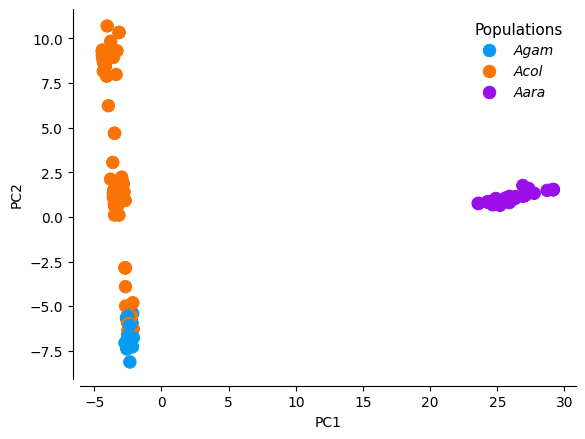

In [81]:
fig, ax = plt.subplots()
sns.despine(fig, ax=ax, offset=5)

sns.scatterplot(data=pca_df, x='PC1', y='PC2', markers=marker1, hue='taxon1', style=None,
                palette=color1,s=80, ec=None,ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,ncol=1,title ='Populations',alignment='left',frameon=False,
         title_fontproperties={'size':11, 'weight':'normal'},
         prop={'size':10, 'style': 'italic'})
#fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/PCA_pop.png',dpi=300, bbox_inches='tight')


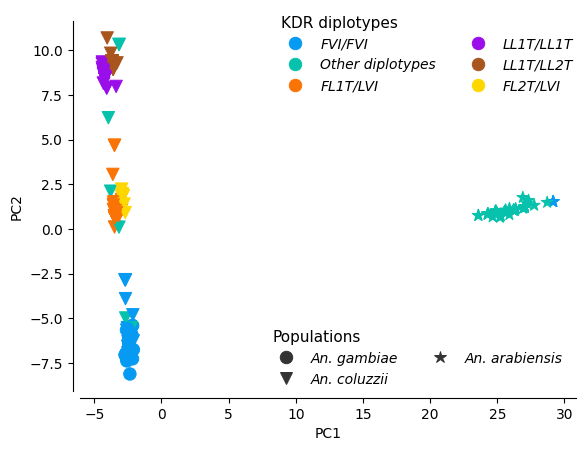

In [112]:
fig, ax = plt.subplots()
sns.despine(fig, ax=ax, offset=5)

sns.scatterplot(data=pca_df, x='PC1', y='PC2', markers=marker, hue='diplo_label', style='taxon',
                palette=color_diplos,s=80, ec=None,ax=ax)
handles, labels = ax.get_legend_handles_labels()
kl1,kl2 = len(color_diplos.keys()), len(labels)
lek = list(marker.keys())
ax.legend(handles[1:1+kl1], labels[1:1+kl1],ncol=2,title ='KDR diplotypes',alignment='left',
         loc='upper right', bbox_to_anchor=(1.02,1.05),title_fontproperties={'size':11, 'weight':'normal'},
         frameon=False,prop={'size':10, 'style': 'italic'})
aleg = Legend(ax, handles[2+kl1:kl2], labels[2+kl1:kl2], title='Populations',ncol=2,
             alignment='left',bbox_to_anchor=(1,0.2), prop={'size':10, 'style': 'italic'},
             title_fontproperties={'size':11, 'weight':'normal'},
             frameon=False)
ax.add_artist(aleg)
fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/PCA_diplo_pop.png',dpi=300, bbox_inches='tight')

/tmp/ipython-input-1285745058.py:9: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend([''], [''],ncol=1,title ='',alignment='left',


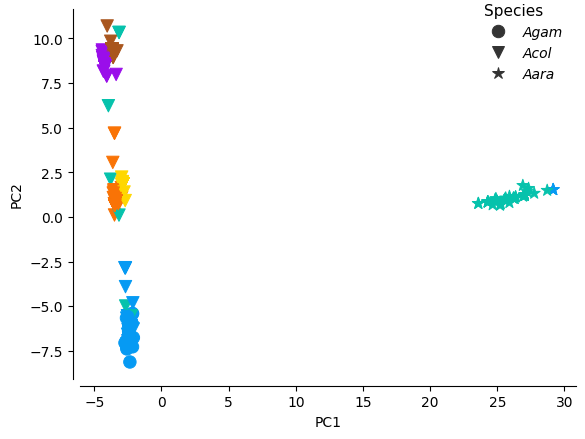

In [83]:
fig, ax = plt.subplots()
sns.despine(fig, ax=ax, offset=5)

sns.scatterplot(data=pca_df, x='PC1', y='PC2', markers=marker1, hue='diplo_labels', style='taxon1',
                palette=colors_diplo,s=80, ec=None,ax=ax)
handles, labels = ax.get_legend_handles_labels()
kl1,kl2 = len(colors_diplo.keys()), len(labels)
lek = list(marker.keys())
ax.legend([''], [''],ncol=1,title ='',alignment='left',
         loc='upper left', bbox_to_anchor=(0.5,0.05),title_fontproperties={'size':11, 'weight':'normal'},
         frameon=False,prop={'size':10, 'style': 'italic'})
aleg = Legend(ax, handles[2+kl1:kl2], labels[2+kl1:kl2], title='Species',
             alignment='left',bbox_to_anchor=(1.0,1.05), prop={'size':10, 'style': 'italic'},
             title_fontproperties={'size':11, 'weight':'normal'},
             frameon=False)
ax.add_artist(aleg)
fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/PCA_diplo_pop1.png',dpi=300, bbox_inches='tight')

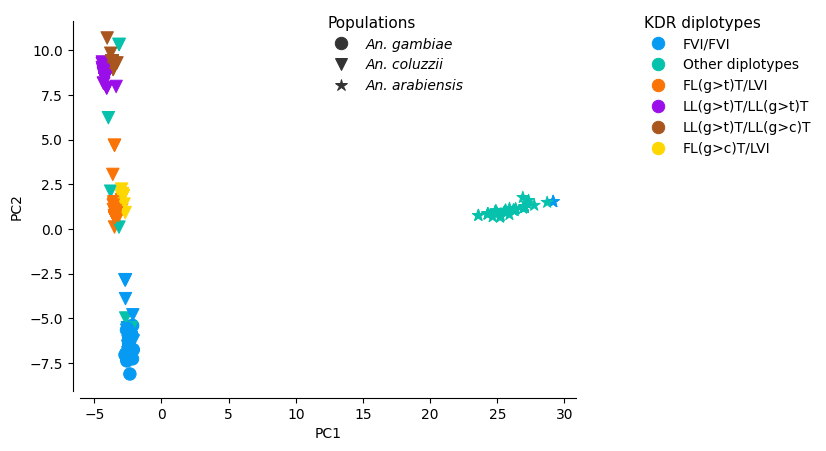

In [84]:
fig, ax = plt.subplots()
sns.despine(fig, ax=ax, offset=5)

sns.scatterplot(data=pca_df, x='PC1', y='PC2', markers=marker, hue='diplo_labels', style='taxon',
                palette=colors_diplo,s=80, ec=None,ax=ax)
handles, labels = ax.get_legend_handles_labels()
kl1,kl2 = len(colors_diplo.keys()), len(labels)
lek = list(marker.keys())
ax.legend(handles[1:1+kl1], labels[1:1+kl1],ncol=1, title ='KDR diplotypes', alignment='left',
         loc='upper right', bbox_to_anchor=(1.5,1.05),title_fontproperties={'size':11, 'weight':'normal'},
         frameon=False)
aleg = Legend(ax, handles[2+kl1:kl2], labels[2+kl1:kl2], title='Populations',
             alignment='left',bbox_to_anchor=(0.8,1.05), prop={'size':10, 'style': 'italic'},
             title_fontproperties={'size':11, 'weight':'normal'},
             frameon=False)
ax.add_artist(aleg)

## Compute fst

In [85]:
def compute_pair_fst(pops):
  # order is irrelevant
  pop1, pop2 = pops
  ac_pop1 = load_ac(pop=pop1)
  ac_pop2 = load_ac(pop=pop2)
  loc_pass = ac_pop1.is_variant() & ac_pop2.is_variant()
  ac1 = ac_pop1[loc_pass]
  ac2 = ac_pop2[loc_pass]

  # compute Fst
  fst_val, den_val = allel.hudson_fst(ac1, ac2, fill=0)

  return np.nansum(fst_val)/np.nansum(den_val)

def compute_pairwise_fst(pop_coh):
  pairwise_fst = []
  pop_list = []

  #compute fst
  for pop1, pop2 in itertools.combinations(pop_coh, 2):
    #print(pop1,pop2)
    pops = tuple(sorted([pop1, pop2]))
    pop_list.append(pop1+'_vs_'+pop2)
    pairwise_fst.append(compute_pair_fst(pops=pops))
  return pairwise_fst, pop_list

def plot_pairwise_fst1(fst, pop_coh, pop_labels, figsize=(4, 4), xlabel=None, ylabel=None, mask=True,
                      ax=None, chrom=None, fs=10, fmt='.4f',fig_name=None, yt=1):

    plt.rcdefaults()
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        sns.despine(ax=ax, top=True, bottom=False, offset=0)

    # plot Fst
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [pop_coh.index(p) for p in pop_coh]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, cmap=(sns.light_palette((50, 90, 60), input="husl")),square=True,
                mask=mask, cbar=False, annot=True, fmt=f'{fmt}', linewidths=.5,)

    # set ticks
    xtl = [pop_labels[p] for p in pop_coh]
    ytl = list(xtl)#[::-1]
    #ax.set_ylabel('$Ne.m$')
    #ax.set_xlabel(f'{chrom}' + r' - $F_{ST}$')
    if chrom is not None:
      ax.set_title(f'{chrom}' + r' - $F_{ST}$', loc='center', y=yt)
    #ax.xaxis.set_label_position('top')
    #ax.yaxis.set_label_position('right')

    # xticks
    if xlabel==True:
      ax.xaxis.tick_bottom()
      ax.set_xticks(np.arange(len(xtl)) + .5)
      ax.set_xticklabels(xtl, rotation=30, ha='right', fontstyle='italic', fontsize=fs)
      ax.tick_params(length=0, pad=3)
    else:
      ax.set_xticklabels('')
      ax.set_xticks([])
    # yticks
    if ylabel==True:
      ax.set_yticklabels(ytl, rotation=0, ha='right', fontstyle='italic', fontsize=fs)
      ax.tick_params(length=0, pad=3)
    else:
      ax.set_yticklabels('')
      ax.set_yticks([])

      # Save fig
    if fig_name:
      fig.savefig(f"drive/MyDrive/sanger_analyses/resistance/VGSC/save_fig/{fig_name}1.png", dpi=300, bbox_inches='tight',transparent=False)


In [86]:
stats_fst, pop_list = compute_pairwise_fst(pop_coh=sorted(select_pop1))
stats_fst1, pop_list1 = compute_pairwise_fst(pop_coh=sorted(select_pop2))
stats_fst12, pop_list12 = compute_pairwise_fst(pop_coh=select_pop12)
stats_fst21, pop_list21 = compute_pairwise_fst(pop_coh=select_pop21)

In [87]:
#pop_list12

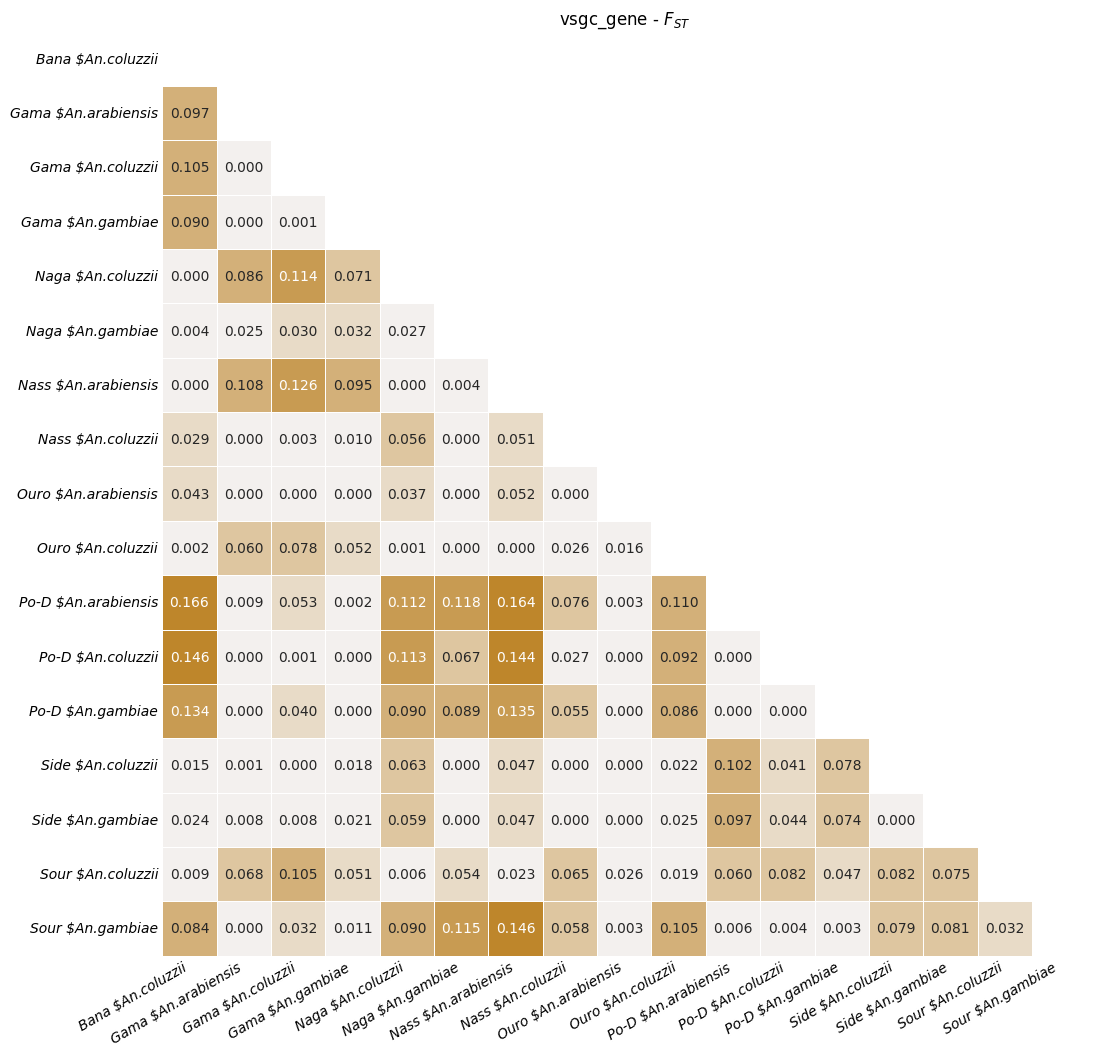

In [88]:
plot_pairwise_fst1(fst=stats_fst, pop_coh=sorted(select_pop1),pop_labels=pop_labels, xlabel=True,figsize=(12,12),
                   ylabel=True, chrom='vsgc_gene',fs=10, fmt='.3f')

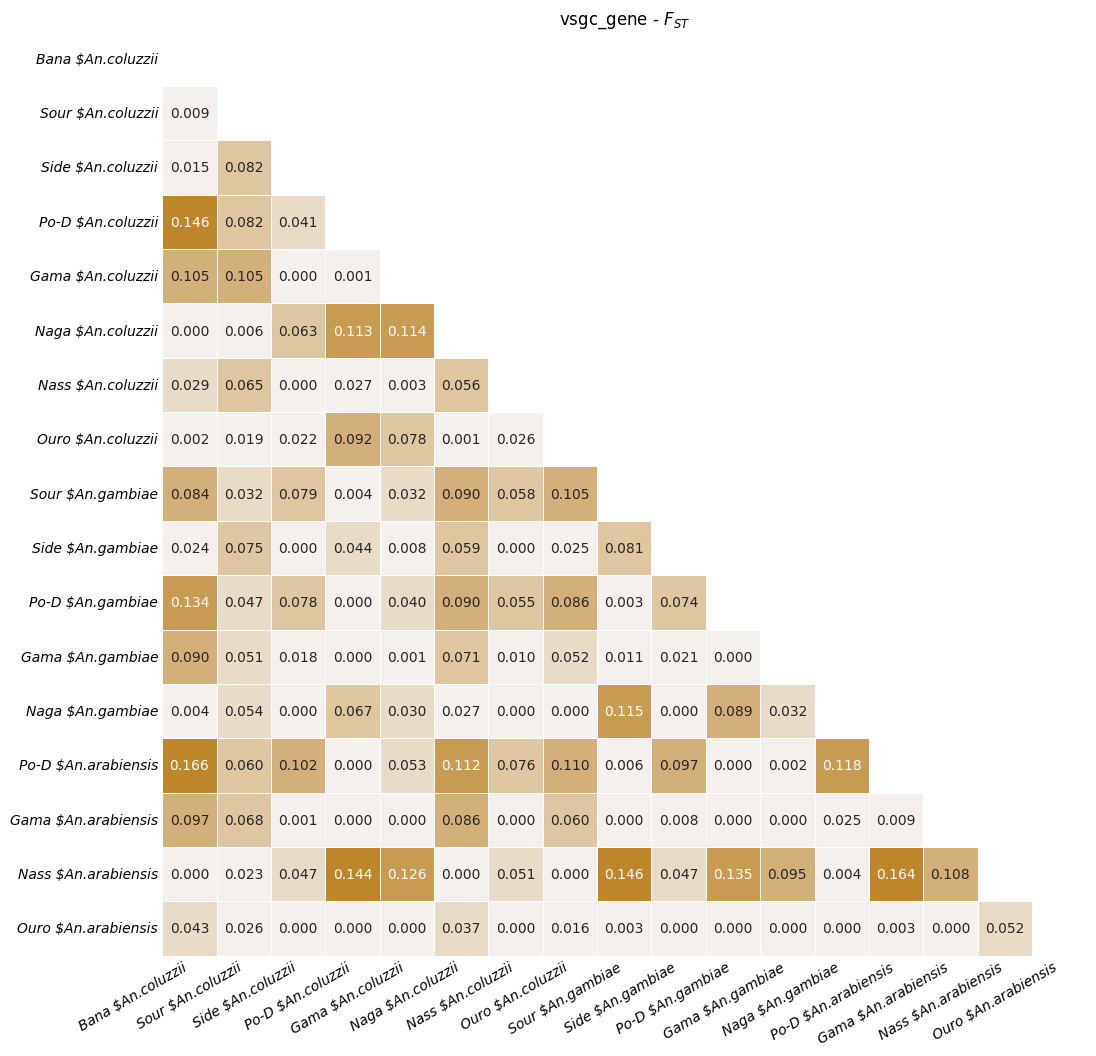

In [89]:
plot_pairwise_fst1(fst=stats_fst12, pop_coh=select_pop12,pop_labels=pop_labels, xlabel=True,figsize=(12,12),
                   ylabel=True, chrom='vsgc_gene',fs=10, fmt='.3f',fig_name='FST_pop')

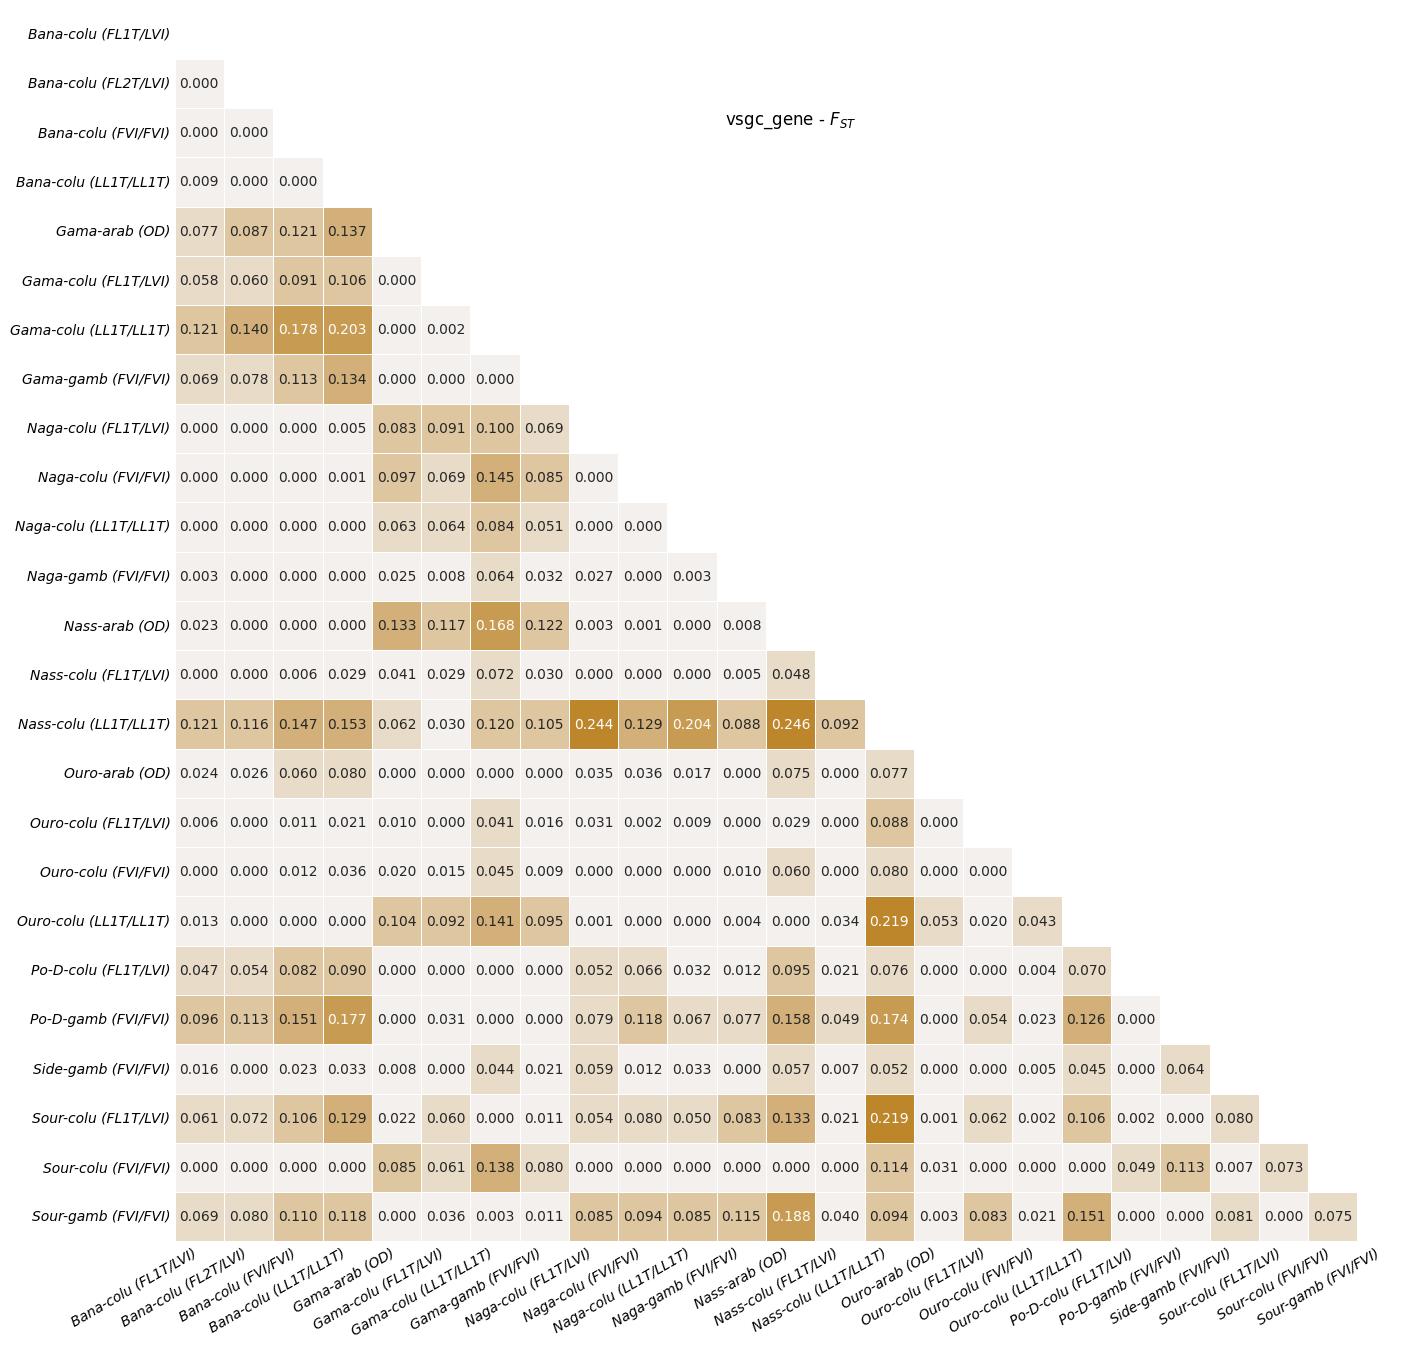

In [90]:
plot_pairwise_fst1(fst=stats_fst1, pop_coh=sorted(select_pop2),pop_labels=pop_labels_h, xlabel=True,figsize=(16,16),
                   ylabel=True, chrom='vsgc_gene',fs=10, fmt='.3f', yt=0.9)

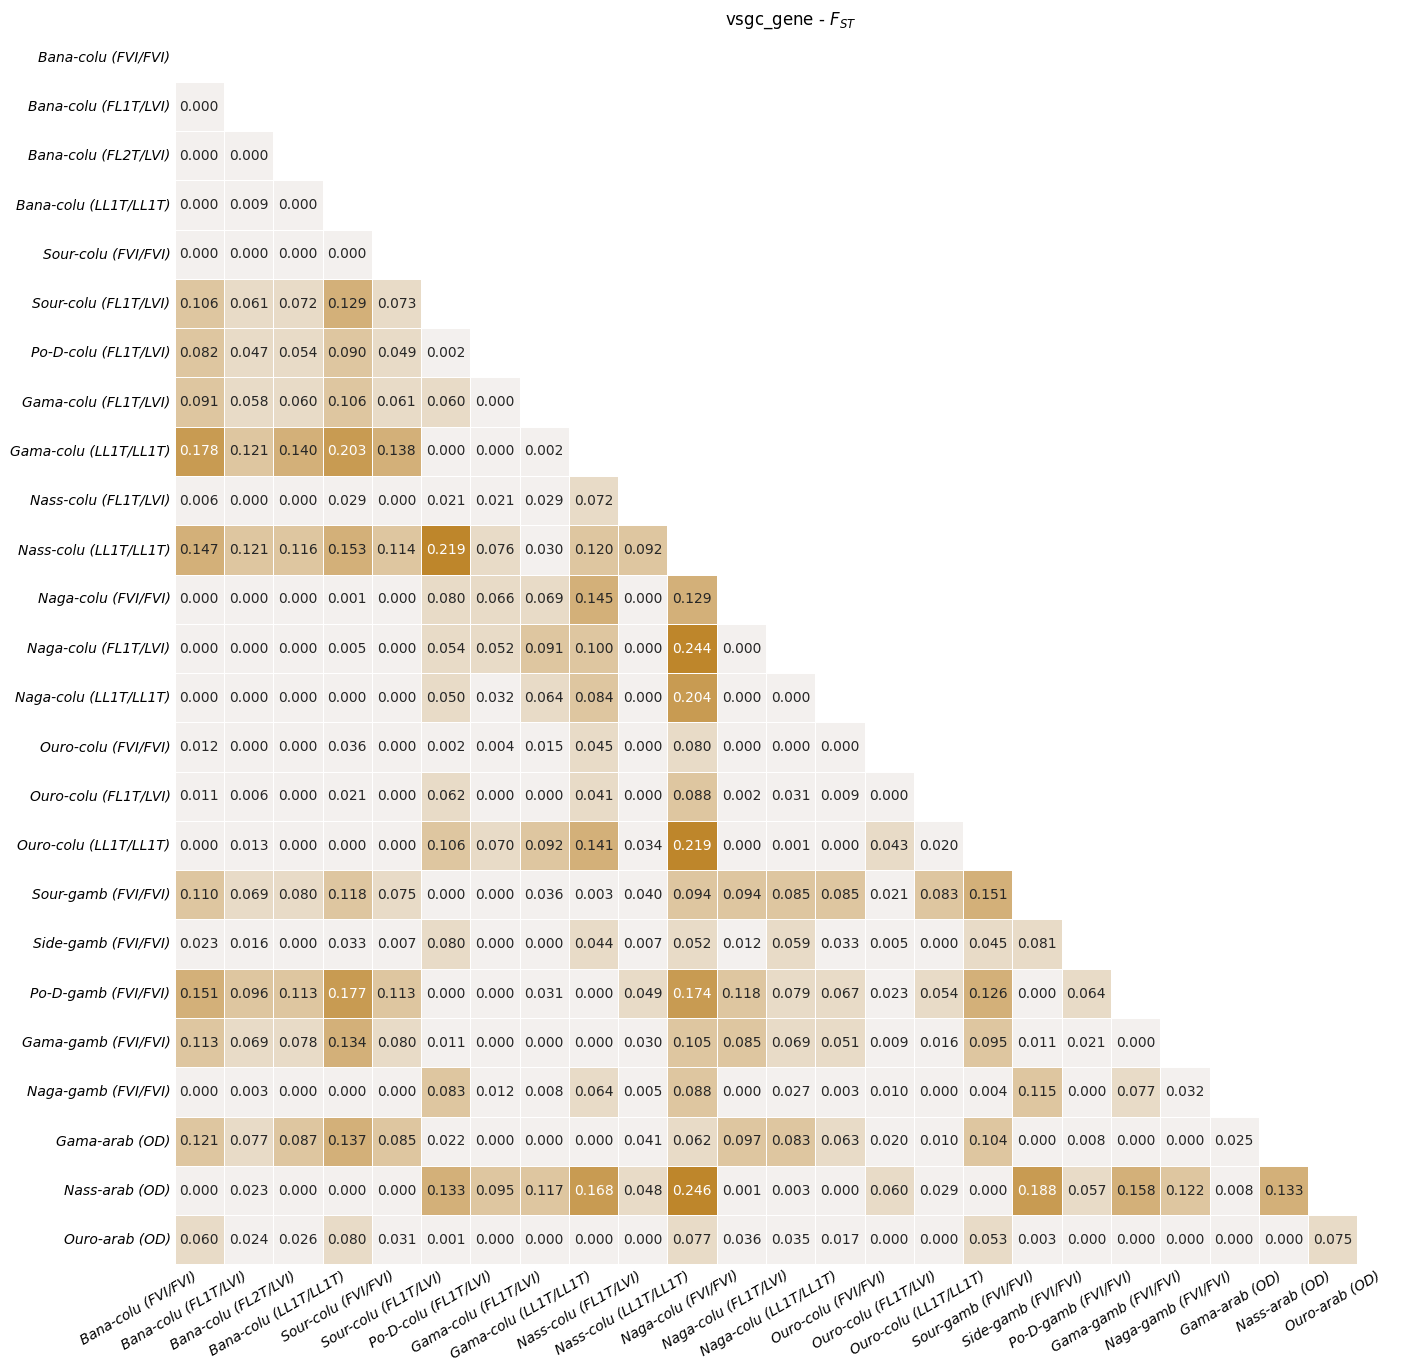

In [91]:
plot_pairwise_fst1(fst=stats_fst21, pop_coh=select_pop21,pop_labels=pop_labels_h, xlabel=True,figsize=(16,16),
                   ylabel=True, chrom='vsgc_gene',fs=10, fmt='.3f',fig_name='FST_pop-var')

In [92]:
## selected populations
select_pop12_col = [key for key in select_pop12 if key.split('_')[1]=='col']
select_pop12_gam = [key for key in select_pop12 if key.split('_')[1]=='gam']
select_pop12_ara = [key for key in select_pop12 if key.split('_')[1]=='ara']

select_pop21_col = [key for key in select_pop21 if key.split('_')[1]=='col']
select_pop21_gam = [key for key in select_pop21 if key.split('_')[1]=='gam']
select_pop21_ara = [key for key in select_pop21 if key.split('_')[1]=='ara']

In [93]:
stat_fst_col, pop_list_col = compute_pairwise_fst(pop_coh=select_pop12_col)
stat_fst_gamb, pop_list_gamb = compute_pairwise_fst(pop_coh=select_pop12_gam)
stat_fst_ara, pop_list_ara = compute_pairwise_fst(pop_coh=select_pop12_ara)

stat_fst_col1, pop_list_col1 = compute_pairwise_fst(pop_coh=select_pop21_col)
stat_fst_gamb1, pop_list_gamb1 = compute_pairwise_fst(pop_coh=select_pop21_gam)
stat_fst_ara1, pop_list_ara1 = compute_pairwise_fst(pop_coh=select_pop21_ara)

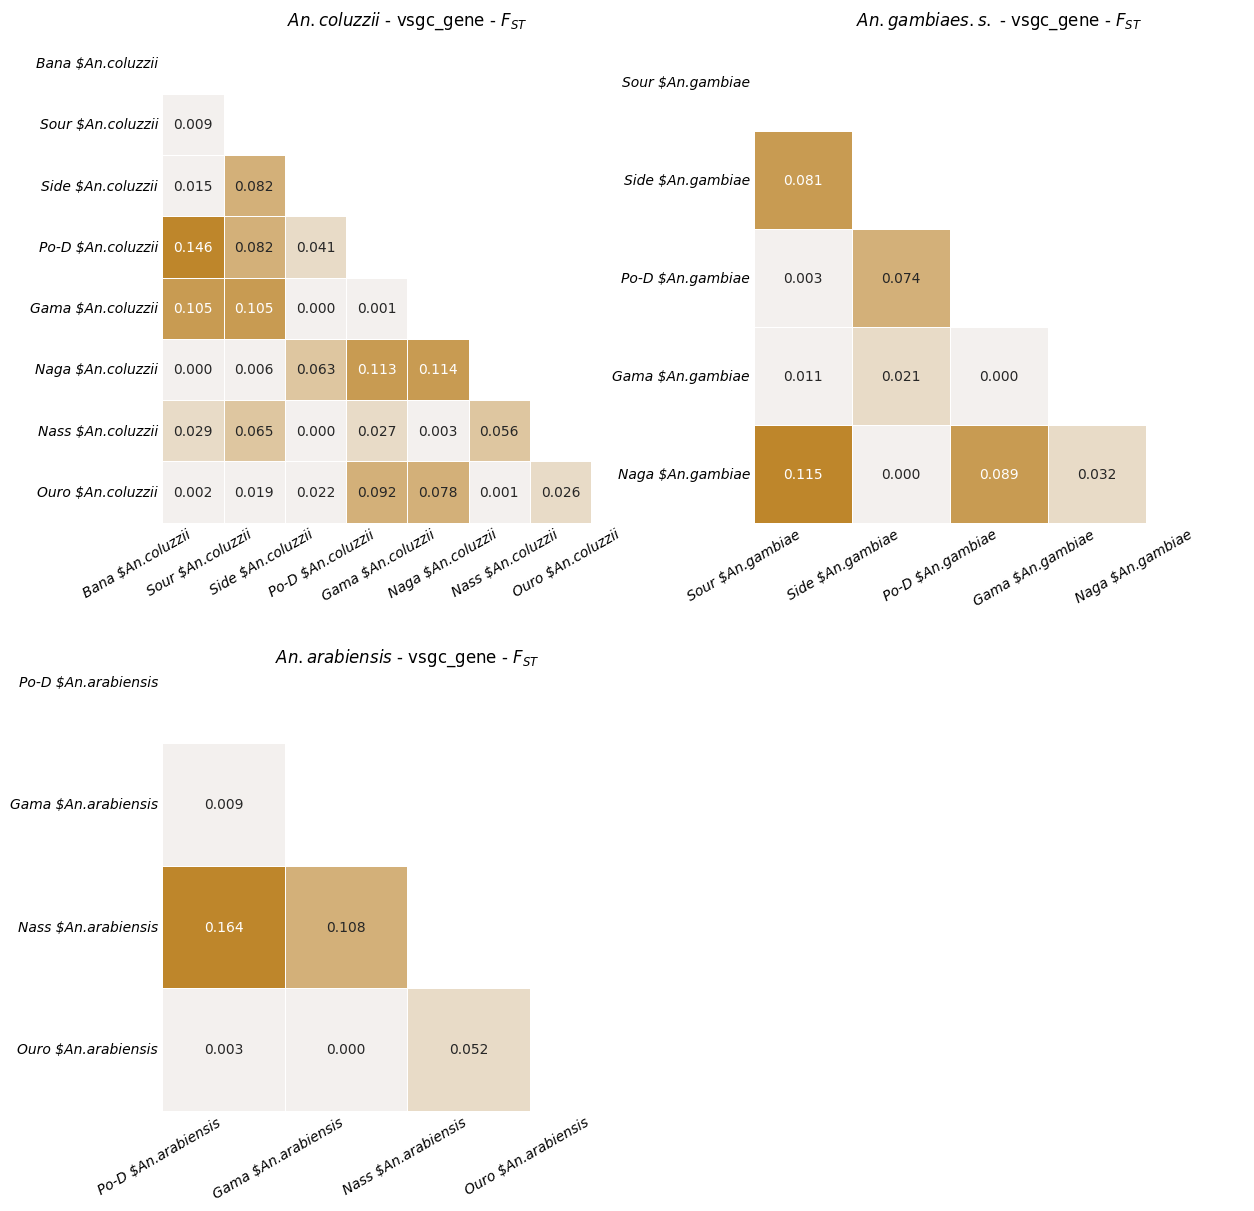

In [94]:
fig = plt.figure(figsize=(14,14))
gs = GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
plot_pairwise_fst1(fst=stat_fst_col, pop_coh=select_pop12_col,pop_labels=pop_labels, xlabel=True,figsize=(6,6),
                   ylabel=True, chrom='$An. coluzzii$ - vsgc_gene',fs=10, fmt='.3f', ax=ax0)

ax1 = fig.add_subplot(gs[0, 1])
plot_pairwise_fst1(fst=stat_fst_gamb, pop_coh=select_pop12_gam,pop_labels=pop_labels, xlabel=True,figsize=(3.5,3.5),
                   ylabel=True, chrom='$An. gambiae s.s.$ - vsgc_gene',fs=10, fmt='.3f', ax=ax1)

ax2 = fig.add_subplot(gs[1, 0])
plot_pairwise_fst1(fst=stat_fst_ara, pop_coh=select_pop12_ara,pop_labels=pop_labels, xlabel=True,figsize=(2,2),
                   ylabel=True, chrom='$An. arabiensis$ - vsgc_gene',fs=10, fmt='.3f', ax=ax2, yt=0.9)

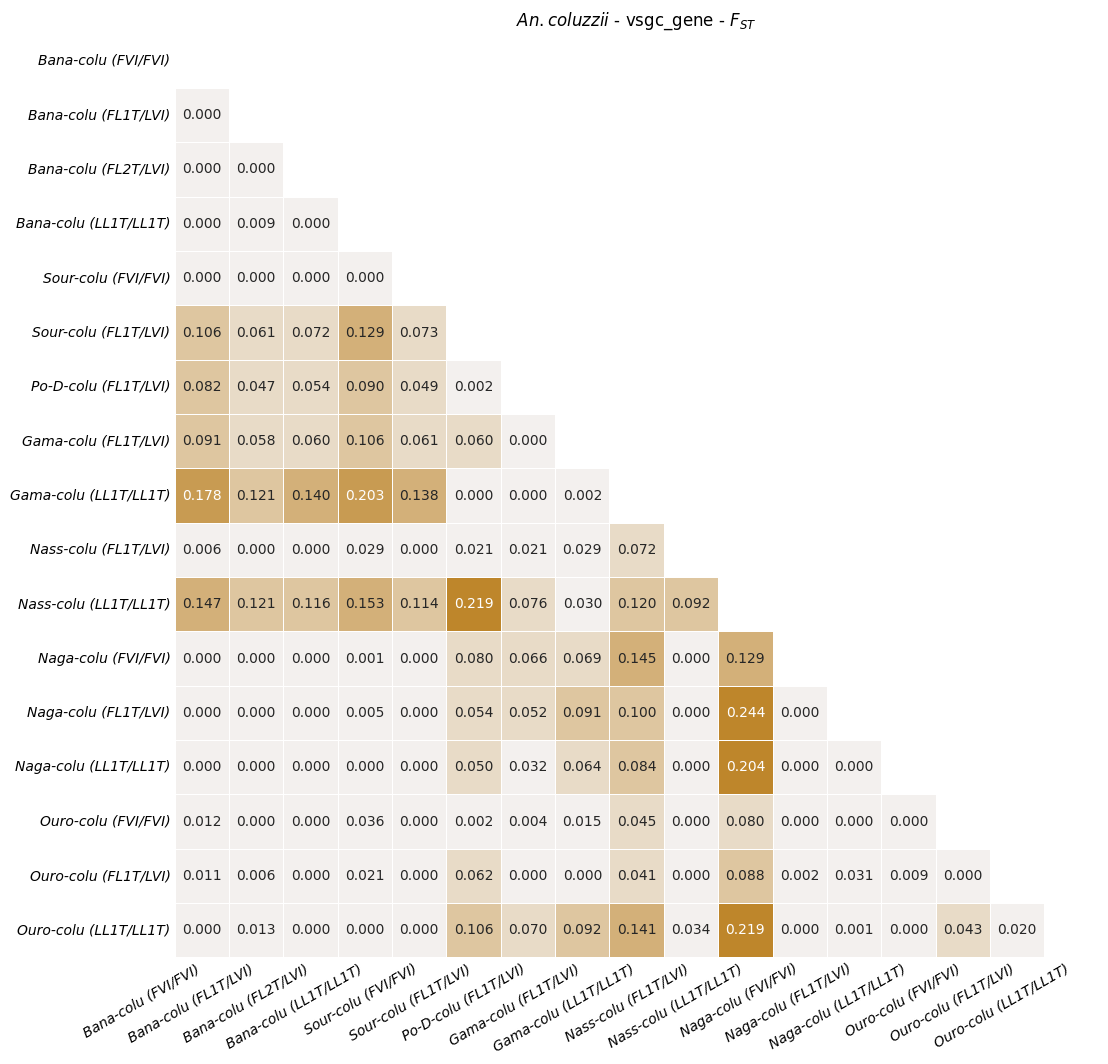

In [95]:
plot_pairwise_fst1(fst=stat_fst_col1, pop_coh=select_pop21_col,pop_labels=pop_labels_h, xlabel=True,figsize=(12,12),
                   ylabel=True, chrom='$An. coluzzii$ - vsgc_gene',fs=10, fmt='.3f')

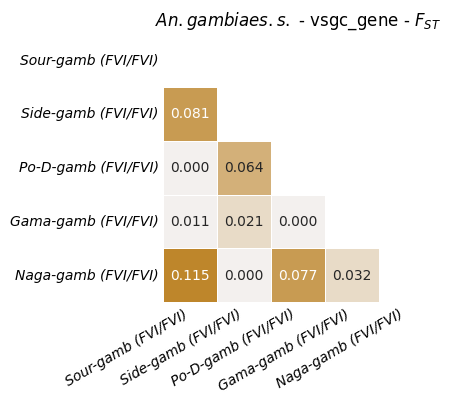

In [96]:
plot_pairwise_fst1(fst=stat_fst_gamb1, pop_coh=select_pop21_gam,pop_labels=pop_labels_h, xlabel=True,figsize=(3.5,3.5),
                   ylabel=True, chrom='$An. gambiae s.s.$ - vsgc_gene',fs=10, fmt='.3f')

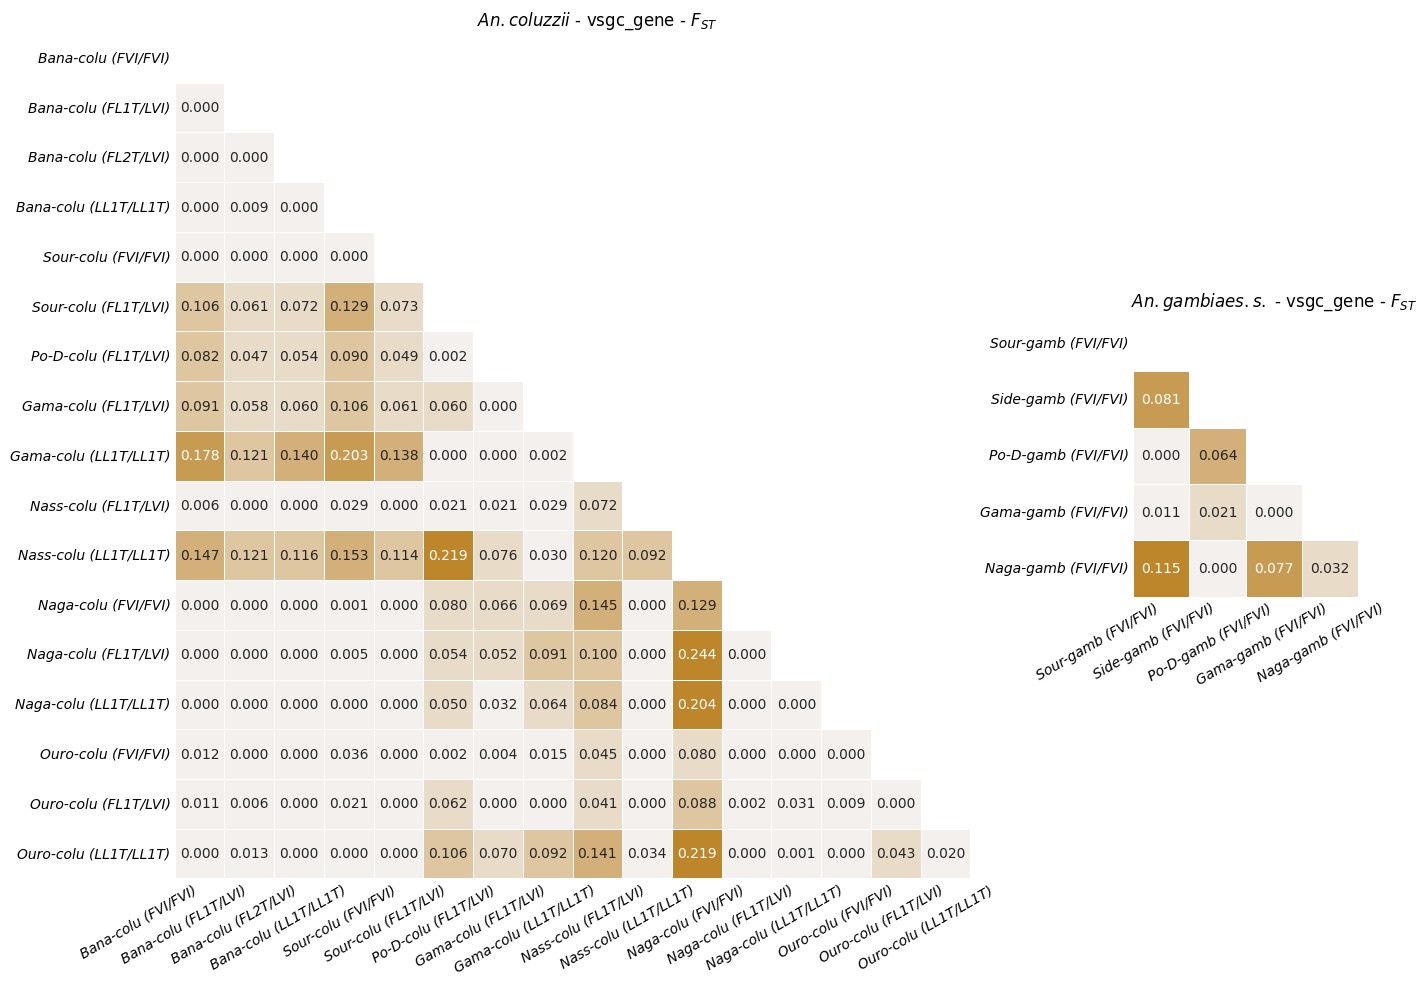

In [97]:
fig = plt.figure(figsize=(16,16))
gs = GridSpec(1, 2, width_ratios=(3,1), height_ratios=(3,))

ax0 = fig.add_subplot(gs[0, 0])
plot_pairwise_fst1(fst=stat_fst_col1, pop_coh=select_pop21_col,pop_labels=pop_labels_h, xlabel=True,figsize=(10,10),
                   ylabel=True, chrom='$An. coluzzii$ - vsgc_gene',fs=10, fmt='.3f', ax=ax0)

ax1 = fig.add_subplot(gs[0, 1])
plot_pairwise_fst1(fst=stat_fst_gamb1, pop_coh=select_pop21_gam,pop_labels=pop_labels_h, xlabel=True,figsize=(3.5,3.5),
                   ylabel=True, chrom='$An. gambiae s.s.$ - vsgc_gene',fs=10, fmt='.3f', ax=ax1)

#plt.savefig(f"VGSC/save_fig/Fst_AC_AG.png", dpi=300, bbox_inches='tight',transparent=False)


## PCA and FST

In [98]:
#fig = plt.figure(figsize=(20,20))
#gs = GridSpec(1, 2, width_ratios=(3,1), height_ratios=(3,))

#ax0 = fig.add_subplot(gs[0, 0])
#plot_pairwise_fst1(fst=stats_fst21, pop_coh=select_pop21,pop_labels=pop_labels_h, xlabel=True,figsize=(18,18),
#                   ylabel=True, fs=10, fmt='.2f', ax=ax0)

#ax1 = fig.add_subplot(gs[0, 1])

#sns.scatterplot(data=pca_df, x='PC1', y='PC2', markers=marker, hue='diplo_labels', style='taxon',
#                palette=colors_diplo,s=80, ec=None,ax=ax1)
#handles, labels = ax1.get_legend_handles_labels()
#kl1,kl2 = len(colors_diplo.keys()), len(labels)
#lek = list(marker.keys())
#ax1.legend(handles[1:1+kl1], labels[1:1+kl1],ncol=1,title ='KDR diplotypes',alignment='left',
#         loc='upper right', bbox_to_anchor=(1.5,1.05),title_fontproperties={'size':11, 'weight':'black'},
#         frameon=False)
#aleg = Legend(ax1, handles[2+kl1:kl2], labels[2+kl1:kl2], title='Populations',
#             alignment='left',bbox_to_anchor=(0.8,1.05), prop={'size':11, 'style': 'italic'},
#             title_fontproperties={'size':11, 'weight':'black'},
#             frameon=False)
